In [1]:
import sys
import os

# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Informer-Like

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from foreblocks import ForecastingModel
from foreblocks import TransformerEncoder, TransformerDecoder, AttentionLayer
from foreblocks import Trainer


# Parameters
input_size = 1
hidden_size = 64
num_layers = 1
output_size = 1
target_len = 10
seq_len = 50
total_len = 1000  # Total synthetic time series length

model_params = {
    "input_processor_output_size": 1,
    "hidden_size": 64,
    "nhead": 4,
    "num_encoder_layers": 1,
    "num_decoder_layers": 1,
    "dropout": 0.1,
    "dim_feedforward": 2048,
    "seq_len": 50,
    "target_len": 10,
    "total_len": 1000,
    "input_size": 1,
    "output_size": 1,
    }

# 1. Create encoder and decoder
encoder = TransformerEncoder(
    input_size=model_params.get("input_processor_output_size", 1),
    # hidden_size=model_params.get("hidden_size", 64),
    nhead=model_params.get("nhead", 4),
    num_layers=model_params.get("num_encoder_layers", 1),
    dropout=model_params.get("dropout", 0.1),
    dim_feedforward=model_params.get("dim_feedforward", 2048),
    att_type="prob_sparse",  # Use probabilistic sparse attention
    #use_moe=True,  # Use Mixture of Experts
)

# Create transformer decoder
decoder = TransformerDecoder(
    input_size=model_params.get("input_processor_output_size", 1),
    # hidden_size=model_params.get("hidden_size", 64),
    output_size=output_size,
    nhead=model_params.get("nhead", 2),
    num_layers=model_params.get("num_decoder_layers", 1),
    dropout=model_params.get("dropout", 0.1),
    dim_feedforward=model_params.get("dim_feedforward", 2048),
    informer_like=True,  # Use Informer-like architecture,
    att_type="prob_sparse",  # Use probabilistic sparse attention
    use_moe=True,  # Use Mixture of Experts
)

model = ForecastingModel(
    encoder=encoder,
    decoder=decoder,
    target_len=target_len,
    input_preprocessor=None,
    output_postprocessor=None,
    output_block=None,
    #attention_module=attention_module,
    forecasting_strategy="seq2seq",
    model_type="informer-like",  # Use Informer-like architecture
    teacher_forcing_ratio=0.5,
    output_size=output_size
)

trainer = Trainer(model, optimizer=torch.optim.Adam(model.parameters(), lr=0.001), criterion=nn.MSELoss())

# 2. Generate synthetic time series
time_series = np.sin(np.linspace(0, 30 * np.pi, total_len)) + 0.1 * np.random.randn(total_len)
time_series = torch.tensor(time_series, dtype=torch.float32).unsqueeze(-1)  # Shape: [T, 1]

# 3. Prepare sliding windows for training
def create_sliding_windows(series, input_len, output_len):
    X, Y = [], []
    for i in range(len(series) - input_len - output_len):
        X.append(series[i:i+input_len])
        Y.append(series[i+input_len:i+input_len+output_len])
    return torch.stack(X), torch.stack(Y)

X, Y = create_sliding_windows(time_series, seq_len, target_len)
train_size = int(0.8 * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:], Y[train_size:]
# 3. Prepare sliding windows for training
def create_sliding_windows(series, input_len, output_len):
    X, Y = [], []
    for i in range(len(series) - input_len - output_len):
        X.append(series[i:i+input_len])
        Y.append(series[i+input_len:i+input_len+output_len])
    return torch.stack(X), torch.stack(Y)

X, Y = create_sliding_windows(time_series, seq_len, target_len)
train_size = int(0.8 * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:], Y[train_size:]

# create DataLoader
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
data = trainer.train(train_loader, epochs=50)
trainer.plot_prediction(X_val, Y_val, full_series=time_series, offset=train_size)




ModuleNotFoundError: No module named 'your_project'

# LSTM

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from foreblocks import ForecastingModel
from foreblocks import LSTMDecoder, LSTMEncoder
from foreblocks import Trainer
from foreblocks.att import AttentionLayer

# Parameters
input_size = 1
hidden_size = 64
num_layers = 1
output_size = 1
target_len = 10
seq_len = 50
total_len = 300  # Total synthetic time series length

# 1. Create encoder and decoder
encoder = LSTMEncoder(input_size, hidden_size, num_layers)
decoder = LSTMDecoder(output_size, hidden_size, output_size, num_layers)

attention_module = AttentionLayer(
    method='dot',
    attention_backend='xformers',
    encoder_hidden_size=hidden_size,
    decoder_hidden_size=hidden_size,
)


model = ForecastingModel(
    encoder=encoder,
    decoder=decoder,
    target_len=target_len,
    forecasting_strategy="seq2seq",
    teacher_forcing_ratio=0.5,
    output_size=output_size,
    #attention_module=attention_module,
)

trainer = Trainer(model, optimizer=torch.optim.Adam(model.parameters(), lr=0.001), criterion=nn.MSELoss())

# 2. Generate synthetic time series
time_series = np.sin(np.linspace(0, 30 * np.pi, total_len)) + 0.1 * np.random.randn(total_len)
time_series = torch.tensor(time_series, dtype=torch.float32).unsqueeze(-1)  # Shape: [T, 1]

# 3. Prepare sliding windows for training
def create_sliding_windows(series, input_len, output_len):
    X, Y = [], []
    for i in range(len(series) - input_len - output_len):
        X.append(series[i:i+input_len])
        Y.append(series[i+input_len:i+input_len+output_len])
    return torch.stack(X), torch.stack(Y)

X, Y = create_sliding_windows(time_series, seq_len, target_len)
train_size = int(0.8 * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:], Y[train_size:]

# create DataLoader
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
data = trainer.train(train_loader)
metrics = trainer.metrics(X_val, Y_val)



[Attention] Method: dot, Backend: xformers
[Attention] xformers version: 0.0.30
[Attention] FlashAttention version: 2.7.4.post1


Training:   0%|          | 0/100 [00:00<?, ?epoch/s, epoch=1, train_loss=0.4775, lr=1.00e-03]

Training: 100%|██████████| 100/100 [00:03<00:00, 29.08epoch/s, epoch=100, train_loss=0.0099, lr=1.00e-03]


Validation Forecast Error Metrics:
  MSE   = 0.010943
  RMSE  = 0.104608
  MAE   = 0.083802


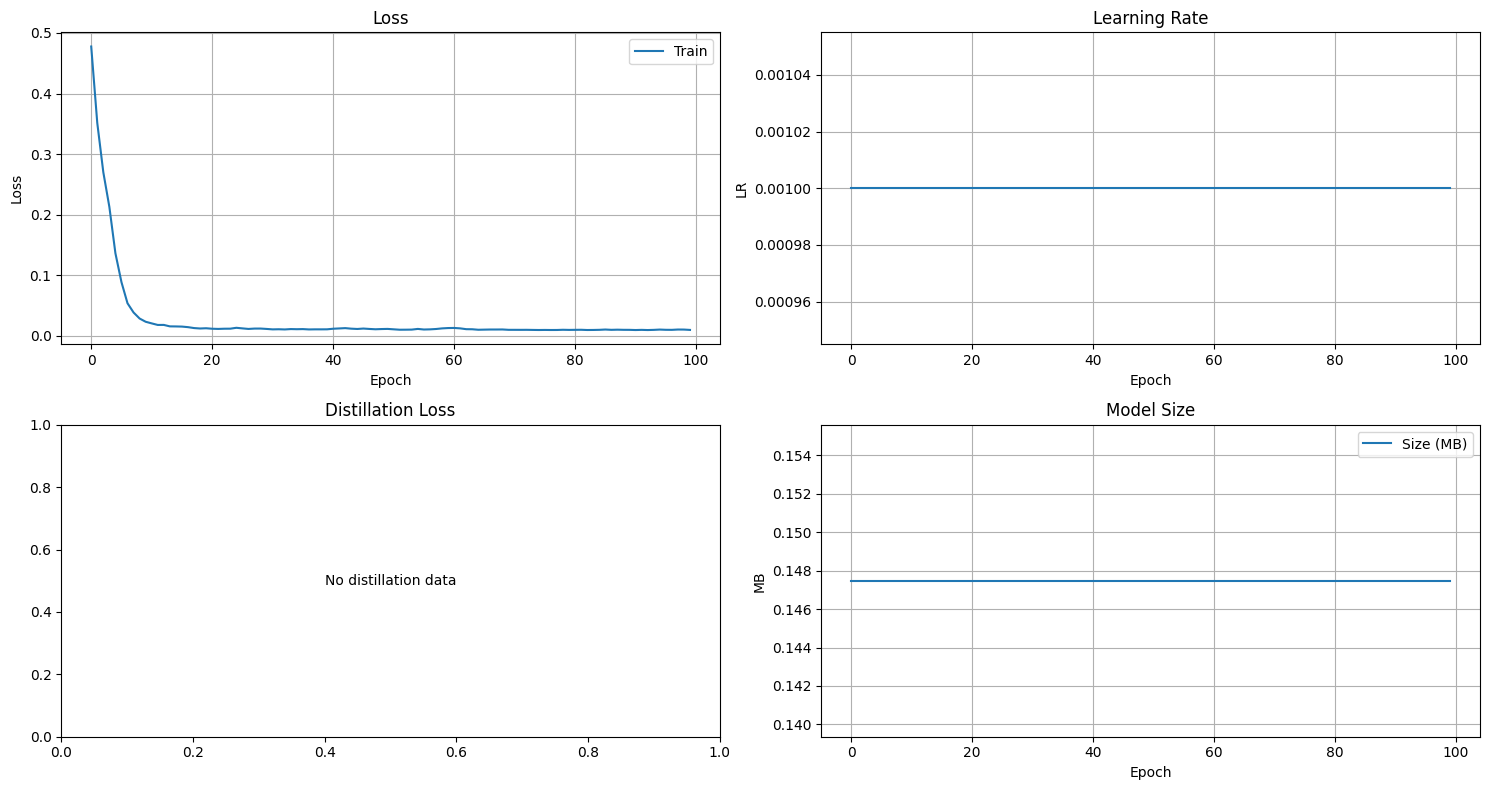

In [ ]:
trainer.plot_learning_curves()

KeyboardInterrupt: 

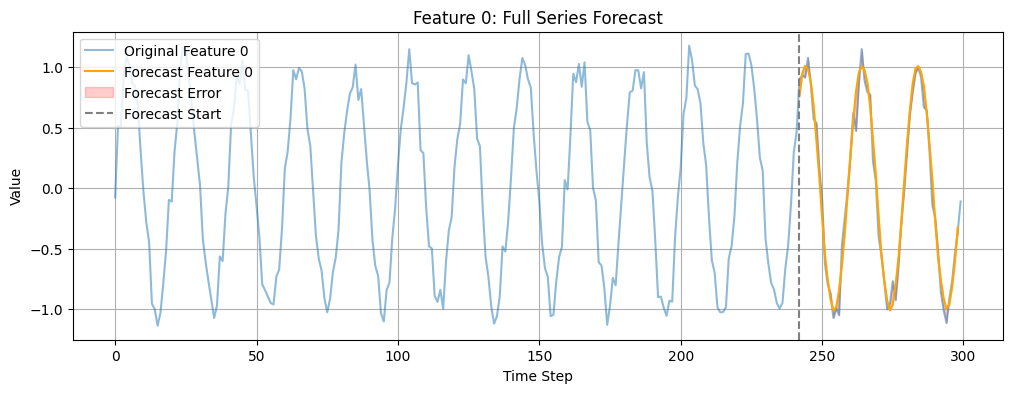

In [ ]:
trainer.plot_prediction(X_val, Y_val, full_series=time_series, offset=train_size)


# Transformer

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from foreblocks import ForecastingModel
from foreblocks import TransformerEncoder, TransformerDecoder, AttentionLayer
from foreblocks import Trainer

# Parameters
input_size = 1
hidden_size = 64
num_layers = 1
output_size = 1
target_len = 10
seq_len = 50
total_len = 1000  # Total synthetic time series length

model_params = {
    "input_processor_output_size": 1,
    "hidden_size": 64,
    "nhead": 4,
    "num_encoder_layers": 1,
    "num_decoder_layers": 1,
    "dropout": 0.1,
    "dim_feedforward": 2048,
    "seq_len": 50,
    "target_len": 10,
    "total_len": 1000,
    "input_size": 1,
    "output_size": 1,
    }

# 1. Create encoder and decoder
encoder = TransformerEncoder(
    input_size=model_params.get("input_processor_output_size", 1),
    # hidden_size=model_params.get("hidden_size", 64),
    nhead=model_params.get("nhead", 4),
    num_layers=model_params.get("num_encoder_layers", 1),
    dropout=model_params.get("dropout", 0.1),
    dim_feedforward=model_params.get("dim_feedforward", 2048),
)

# Create transformer decoder
decoder = TransformerDecoder(
    input_size=model_params.get("input_processor_output_size", 1),
    # hidden_size=model_params.get("hidden_size", 64),
    output_size=output_size,
    nhead=model_params.get("nhead", 2),
    num_layers=model_params.get("num_decoder_layers", 1),
    dropout=model_params.get("dropout", 0.1),
    dim_feedforward=model_params.get("dim_feedforward", 2048),
)

model = ForecastingModel(
    encoder=encoder,
    decoder=decoder,
    target_len=target_len,
    input_preprocessor=None,
    output_postprocessor=None,
    output_block=None,
    #attention_module=attention_module,
    forecasting_strategy="seq2seq",
    model_type="transformer",
    teacher_forcing_ratio=0.5,
    output_size=output_size
)

trainer = Trainer(model, optimizer=torch.optim.Adam(model.parameters(), lr=0.001), criterion=nn.MSELoss())
#trainer.set_config('num_epochs', 200)
# 2. Generate synthetic time series
time_series = np.sin(np.linspace(0, 30 * np.pi, total_len)) + 0.1 * np.random.randn(total_len)
time_series = torch.tensor(time_series, dtype=torch.float32).unsqueeze(-1)  # Shape: [T, 1]

# 3. Prepare sliding windows for training
def create_sliding_windows(series, input_len, output_len):
    X, Y = [], []
    for i in range(len(series) - input_len - output_len):
        X.append(series[i:i+input_len])
        Y.append(series[i+input_len:i+input_len+output_len])
    return torch.stack(X), torch.stack(Y)

X, Y = create_sliding_windows(time_series, seq_len, target_len)
train_size = int(0.8 * len(X))
X_train, Y_train = X[:train_size], Y[:train_size]
X_val, Y_val = X[train_size:], Y[train_size:]

# create DataLoader
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
data = trainer.train(train_loader)




[FeedForwardBlock] Using standard FFN (SwiGLU)
[MultiAttention] Type: standard, Backends: {'flash': True, 'xformers': True, 'sdp': True, 'softpick': True}
[FeedForwardBlock] Using standard FFN (SwiGLU)
[MultiAttention] Type: standard, Backends: {'flash': True, 'xformers': True, 'sdp': True, 'softpick': True}
[MultiAttention] Type: standard, Backends: {'flash': True, 'xformers': True, 'sdp': True, 'softpick': True}


Training:   3%|▎         | 3/100 [00:01<00:44,  2.20epoch/s, epoch=3, train_loss=0.5376, lr=1.00e-03] 


KeyboardInterrupt: 

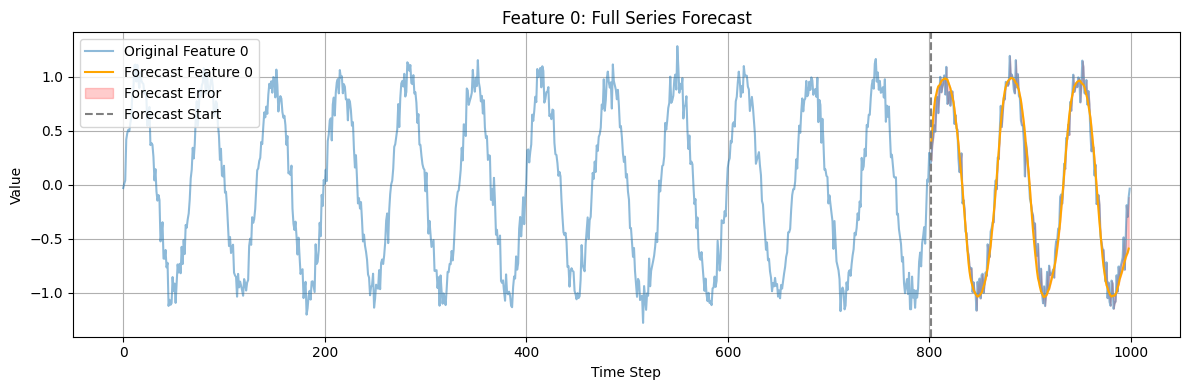

In [ ]:
fig = trainer.plot_prediction(X_val, Y_val, full_series=time_series, offset=train_size)